In [1]:
import pandas as pd
import numpy as np
#import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

sns.set_style("whitegrid")

In [2]:
#data set from kaggle: https://www.kaggle.com/competitions/grupo-bimbo-inventory-demand/data

#office
train = pd.read_csv("train.csv", usecols=['Semana', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil'])
test = pd.read_csv("test.csv", usecols=['Semana', 'Producto_ID', 'Cliente_ID', 'id'])

train = train.rename(columns={'Semana': 'Week_num',
                                  'Agencia_ID': 'Sales_Depot_ID',
                                  'Canal_ID': 'Sales_Channel_ID',
                                  'Ruta_SAK': 'Route_ID',
                                  'Cliente_ID': 'Client_ID',
                                  'Venta_uni_hoy': 'Sales_unit_this_week',
                                  'Venta_hoy': 'Sales_this_week',
                                  'Dev_uni_proxima': 'Returns_unit_next_week',
                                  'Dev_proxima': 'Returns_next_week',
                                  'Demanda_uni_equil': 'adjusted_demand',
                                  'Producto_ID': 'Product_ID'})

test = test.rename(columns={'Semana': 'Week_num',
                                  'Agencia_ID': 'Sales_Depot_ID',
                                  'Canal_ID': 'Sales_Channel_ID',
                                  'Ruta_SAK': 'Route_ID',
                                  'Cliente_ID': 'Client_ID',
                                  'Venta_uni_hoy': 'Sales_unit_this_week',
                                  'Venta_hoy': 'Sales_this_week',
                                  'Dev_uni_proxima': 'Returns_unit_next_week',
                                  'Dev_proxima': 'Returns_next_week',
                                  'Demanda_uni_equil': 'adjusted_demand',
                                  'Producto_ID': 'Product_ID'})



#set a unique id for each client, product combination (thanks Gemini)
combined_df = pd.concat([train,test])
combined_df['ID'] = combined_df.groupby(['Client_ID', 'Product_ID']).ngroup()

train = combined_df.iloc[:len(train)].copy()
test = combined_df.iloc[len(train):].copy()

del combined_df


train = train.drop(columns='id')
train['adjusted_demand'] = train['adjusted_demand'].astype(int)
train = train.sort_values(by=['ID', 'Week_num']).reset_index(drop=True)

test = test.drop(columns='adjusted_demand')
test['id'] = test['id'].astype(int)
test = test.sort_values(by=['ID', 'Week_num']).reset_index(drop=True)

In [10]:
#create a dataframe of aggregate statistics for each client

testagg = train.groupby('Client_ID').agg({'Product_ID':'nunique', 'adjusted_demand':['mean', 'median', 'std', 'min', 'max']})
testagg = testagg.reset_index()

client_stats = pd.DataFrame()

client_stats['Client_ID'] = train['Client_ID'].unique()
client_stats['Products'] = testagg['Product_ID']['nunique']
client_stats['adj_dem_mean'] = testagg['adjusted_demand']['mean'].round(2)
client_stats['adj_dem_median'] = testagg['adjusted_demand']['median'].astype(int)
client_stats['adj_dem_std'] = testagg['adjusted_demand']['std'].round(2)
client_stats['adj_dem_min'] = testagg['adjusted_demand']['min']
client_stats['adj_dem_max'] = testagg['adjusted_demand']['max']

client_stats.head()

,Client_ID,Products,adj_dem_mean,adj_dem_median,adj_dem_std,adj_dem_min,adj_dem_max
0,26,51,28.10,20,26.62,0,132
1,60,34,188.83,130,228.27,11,2304
2,65,112,109.10,60,140.54,0,1669
3,101,4,81.60,28,86.40,20,280
4,105,72,50.36,26,57.83,2,459


In [11]:
client_stats.tail()

,Client_ID,Products,adj_dem_mean,adj_dem_median,adj_dem_std,adj_dem_min,adj_dem_max
880599,11011586,58,16.92,12,13.82,1,64
880600,11693264,88,11.19,6,14.56,0,100
880601,19988629,15,2.85,2,2.84,1,15
880602,99999999,18,2.17,1,3.95,1,20
880603,2015152015,16,24.77,10,63.96,1,400


In [21]:
#create a dataframe of aggregate statistics for each product
del testagg
testagg = train.groupby('Product_ID').agg({'Client_ID':'nunique', 'adjusted_demand':['mean', 'median', 'std', 'min', 'max']})
testagg = testagg.reset_index()

product_stats = pd.DataFrame()

product_stats['Product_ID'] = train['Product_ID'].unique()
product_stats['Clients'] = testagg['Client_ID']['nunique']
product_stats['adj_dem_mean'] = testagg['adjusted_demand']['mean'].round(2)
product_stats['adj_dem_median'] = testagg['adjusted_demand']['median'].astype(int)
product_stats['adj_dem_std'] = testagg['adjusted_demand']['std'].round(2)
product_stats['adj_dem_min'] = testagg['adjusted_demand']['min']
product_stats['adj_dem_max'] = testagg['adjusted_demand']['max']

product_stats.head()

,Product_ID,Clients,adj_dem_mean,adj_dem_median,adj_dem_std,adj_dem_min,adj_dem_max
0,1182,15,367.44,70,532.94,0,2064
1,4767,45,291.10,119,409.19,0,1919
2,30235,67417,4.90,4,5.16,0,659
3,30314,59643,3.19,2,7.71,0,450
4,31393,40,8.81,3,11.83,0,52


In [25]:
print(len(train[train['Product_ID'] == 1182]['Client_ID'].unique()))

print(train[train['Product_ID'] == 1182]['adjusted_demand'].mean())

242967
8.046851726019327


In [48]:
print(len(train['Product_ID'].unique()))

print(len(product_stats['Product_ID'].unique()))

1799
1799


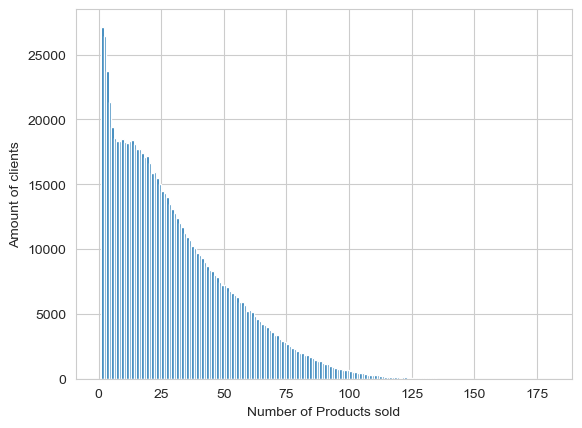

In [53]:
plt.hist(client_stats['Products'], bins=np.arange(0,len(client_stats['Products'].unique())))

plt.ylabel("Amount of clients")
plt.xlabel("Number of Products sold")


plt.show()

In [35]:
product_stats[product_stats['Unique_Clients'] == 2]

,Product_ID,Unique_Clients,adj_dem_mean,adj_dem_median,adj_dem_std,adj_dem_min,adj_dem_max
113,35052,2,78.50,78,58.69,37,120
132,43161,2,10.50,10,7.78,5,16
146,43341,2,32.50,32,44.55,1,64
148,43388,2,2.00,2,1.41,1,3
169,34495,2,78.60,42,70.63,30,197
...,...,...,...,...,...,...,...
1722,35441,2,19.88,17,12.56,6,36
1725,4109,2,122.50,122,173.24,0,245
1757,34644,2,0.00,0,0.00,0,0
1775,36036,2,27.28,18,25.11,0,149


In [45]:
product_stats[product_stats['Product_ID'] == 1182]

,Product_ID,Unique_Clients,adj_dem_mean,adj_dem_median,adj_dem_std,adj_dem_min,adj_dem_max
0,1182,15,367.44,70,532.94,0,2064


In [44]:
train[train['Product_ID'] == 1182]['Client_ID'].unique()

array([      26,       65,      105, ..., 10351808, 10351814, 11011586],
      shape=(242967,))

In [41]:
len(train)

74180464

In [55]:
testdf = train.groupby(['Product_ID'])

In [57]:
testdf.head(10)

,Week_num,Client_ID,Product_ID,adjusted_demand,ID
0,3,26,1182,39,0
1,7,26,1182,0,0
2,8,26,1182,0,0
3,3,26,4767,42,1
4,7,26,4767,42,1
...,...,...,...,...,...
74172421,3,9847617,34337,102,27109930
74172422,4,9847617,34337,713,27109930
74172423,7,9847617,34337,1020,27109930
74172424,8,9847617,34337,510,27109930


In [40]:
type(testdf)

pandas.core.groupby.generic.DataFrameGroupBy

In [34]:
train[train['Product_ID'] == 49028]['Client_ID'].unique()

array([      26,       65,      105, ...,  9853756,  9881395, 10033178],
      shape=(9357,))

In [33]:
train[train['Product_ID'] == 41]['Client_ID'].unique()

array([ 146030,  465617,  681747,  684023,  685079, 1035265, 1105804,
       1451516, 1546790, 1623763, 1938075, 2284385, 2470338, 2482890,
       4586525])

In [32]:
testagg

Product_ID Client_ID adjusted_demand                             
                  nunique            mean median         std min   max
0            41        15      367.442623   70.0  532.936817   0  2064
1            53        45      291.096491  119.5  409.185701   0  1919
2            72     67417        4.896193    4.0    5.161305   0   659
3            73     59643        3.193657    2.0    7.711981   0   450
4           100        40        8.814516    3.5   11.828288   0    52
...         ...       ...             ...    ...         ...  ..   ...
1794      49992        89       26.375000   22.0   22.908000   0   151
1795      49993         4        9.200000    8.5    6.033241   0    24
1796      49994       510        3.561983    2.0    5.494301   0    72
1797      49996        22       15.375000   11.0   16.583284   1    66
1798      49997         1       14.714286   15.0   11.086242   0    36

[1799 rows x 7 columns]

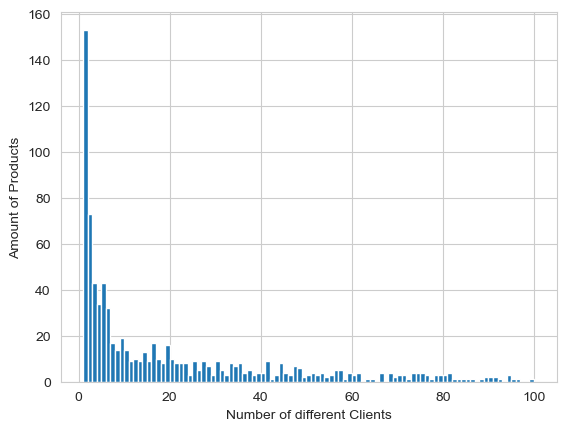

In [28]:
plt.hist(product_stats['Unique_Clients'], bins=np.linspace(1,100,100))

plt.xlabel("Number of different Clients")
plt.ylabel("Amount of Products")


plt.show()

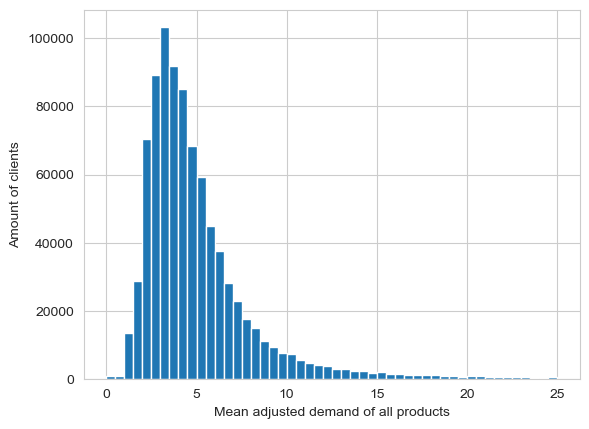

In [75]:
plt.hist(client_stats['adj_dem_mean'], bins=np.linspace(0,25,51))

plt.xlabel("Mean adjusted demand of all products")
plt.ylabel("Amount of clients")

plt.show()

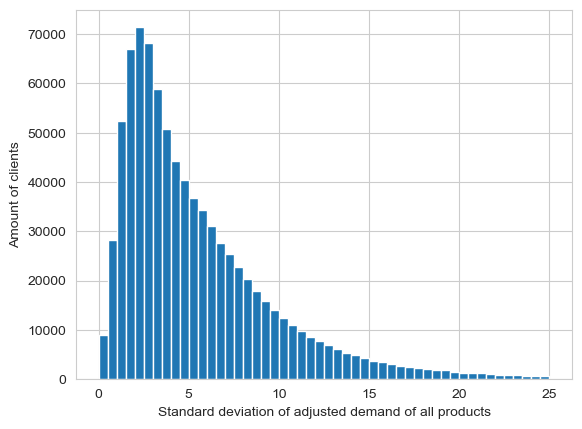

In [76]:
plt.hist(client_stats['adj_dem_std'], bins=np.linspace(0,25,51))

plt.xlabel("Standard deviation of adjusted demand of all products")
plt.ylabel("Amount of clients")

plt.show()

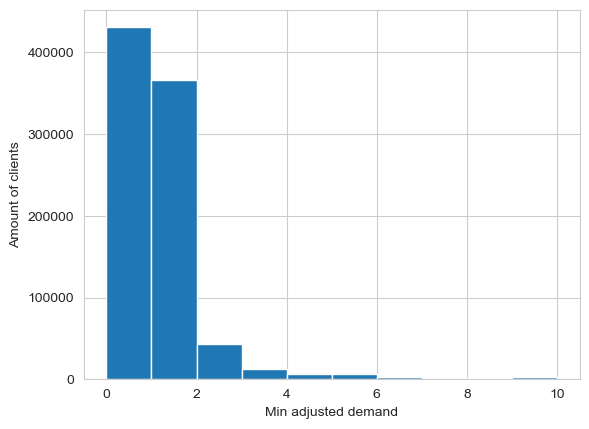

In [68]:
plt.hist(client_stats['adj_dem_min'], bins=np.linspace(0,10,11))

plt.xlabel("Min adjusted demand")
plt.ylabel("Amount of clients")

plt.show()

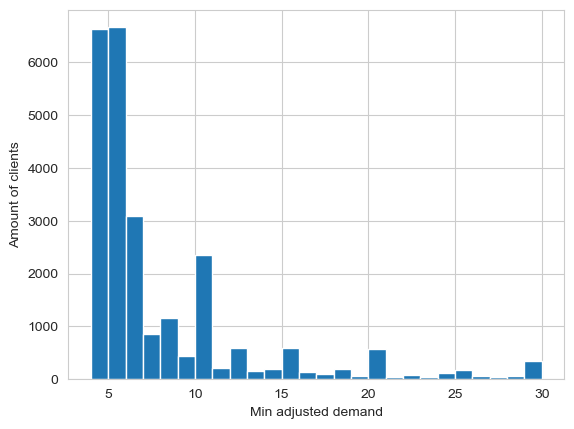

In [85]:
plt.hist(client_stats['adj_dem_min'], bins=np.linspace(4,30,27))

plt.xlabel("Min adjusted demand")
plt.ylabel("Amount of clients")

plt.show()

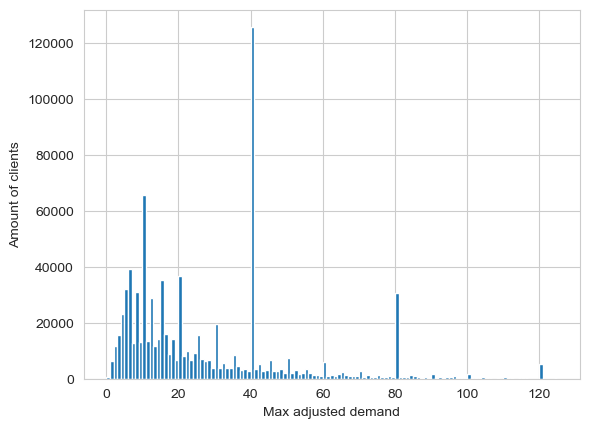

In [74]:
plt.hist(client_stats['adj_dem_max'], bins=np.linspace(0,125,126))

plt.xlabel("Max adjusted demand")
plt.ylabel("Amount of clients")

plt.show()